In [18]:
import os
import sys
import warnings
import numpy as np

sys.path.insert(0, '../seismiqb')

from seismiqb import SeismicCubeset

warnings.filterwarnings("ignore")

In [23]:
PATH = '/data/seismic_data/seismic_interpretation/'
cubes = [dirname for dirname in next(os.walk(PATH))[1] if dirname.startswith('CUBE_')]
cubes

['CUBE_31_CHIST',
 'CUBE_46_YETYPUR',
 'CUBE_03_PRB',
 'CUBE_33_SAMBURG',
 'CUBE_06_TAYLAKOVSKY',
 'CUBE_28_SAMBURG',
 'CUBE_48_VENGAYKHA',
 'CUBE_40_KET',
 'CUBE_42_ZAPZIM',
 'CUBE_34_UKM',
 'CUBE_38_ACHIM',
 'CUBE_08_PSDM',
 'CUBE_41_UJNOE',
 'CUBE_47_VYNGYPUR',
 'CUBE_32_MYUG',
 'CUBE_15_TAYLAKOVSKY',
 'CUBE_39_YY']

In [51]:
for cube in cubes:
    SGY_PATH = f"{PATH}{cube}/amplitudes{cube[4:]}.sgy"
    try:
        ds = SeismicCubeset(SGY_PATH, no_ext=True)
        print(f"Success at loading {cube}")
        try:
            ds.geometries[0].process()
            print(f"Success at processing {cube}")
        except Exception as e:
            print(f"Error processing {cube}")
            print(e)
    except Exception as e:
        print(f"Error loading {cube}")
        print(e)

Success at loading CUBE_31_CHIST
Success at processing CUBE_31_CHIST
Success at loading CUBE_46_YETYPUR
Success at processing CUBE_46_YETYPUR
Success at loading CUBE_03_PRB
Success at processing CUBE_03_PRB
Success at loading CUBE_33_SAMBURG


KeyboardInterrupt: 

In [1]:
import sys
import json
import warnings

import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from scipy.special import expit

LEVELS = '../' * 2
sys.path.insert(0, f'{LEVELS}src')
sys.path.insert(0, f'{LEVELS}seismiqb')

from seismiqb.batchflow import Pipeline
from seismiqb.batchflow import B, V, C, D, P, R, W, L
from seismiqb.batchflow.models.torch import EncoderDecoder, ResBlock

from seismiqb import SeismicCubeset, Horizon
from seismiqb import plot_loss, plot_image

from utils import *

warnings.filterwarnings("ignore")

%env CUDA_VISIBLE_DEVICES=7

env: CUDA_VISIBLE_DEVICES=7


In [2]:
with open('../../notebooks/FANS/04_data_splits/initial', 'r') as handle:
    train_test_split = json.load(handle)
train_test_split

{'TRAIN': {'31_CHIST': ['BV12_CHIST_new.char'],
  '32_MYUG': ['BV9_4_MYUG.char'],
  '33_SAMBURG': ['Ach_5_2_3_SAMB.char', 'Ach6_0_1_SAMB.char'],
  '34_UKM': ['BV9_4_UKM.char']},
 'TEST': {'38_ACHIM': ['BV11_2_Test.char'],
  '39_YY': ['AchBT11_3_Yro_Yha.char']}}

In [3]:
TRAIN_HDF5_PATHS = [f'/data/seismic_data/seismic_interpretation/CUBE_{CUBE_NAME}/amplitudes_{CUBE_NAME}.hdf5'
                    for CUBE_NAME in train_test_split['TRAIN'].keys()]
train_dataset = SeismicCubeset(TRAIN_HDF5_PATHS)

train_dataset.load_corresponding_labels(train_test_split['TRAIN'],
                                        [f'INPUTS/FACIES/{subdir}' for subdir in ('FANS_HORIZONS', 'FANS')],
                                        ['horizons', 'fans'],
                                        main_labels='horizons')
print(train_dataset)

Seismic Cubeset with 4 cubes:
    Inferred geometry for amplitudes_31_CHIST.hdf5: (828x1004x351):
        BV12_CHIST_new.char
    Inferred geometry for amplitudes_32_MYUG.hdf5: (840x1104x351):
        BV9_4_MYUG.char
    Inferred geometry for amplitudes_33_SAMBURG.hdf5: (2901x2840x276):
        Ach_5_2_3_SAMB.char
        Ach6_0_1_SAMB.char
    Inferred geometry for amplitudes_34_UKM.hdf5: (1164x860x352):
        BV9_4_UKM.char



In [12]:
train_dataset.make_grid(cube_name=train_dataset.indices[0], crop_shape=(256, 256, 23), mode='2d', heights=int(train_dataset.labels[0][0].h_mean), overlap_factor=2)

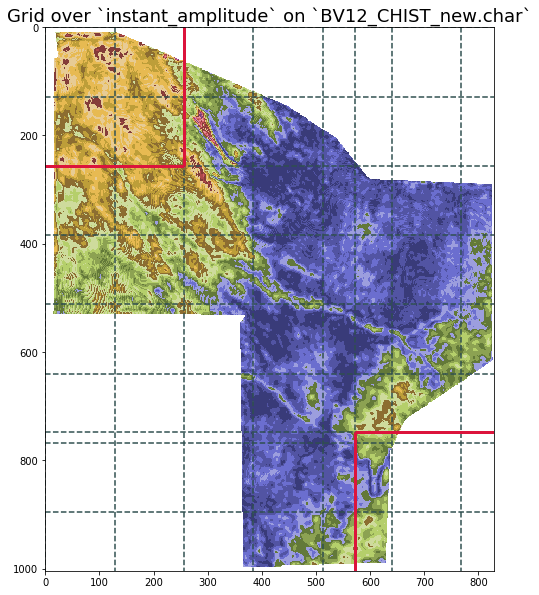

In [16]:
train_dataset.show_grid(attribute='instant_amplitude')

In [ ]:
CROP_SHAPE = (512, 512, 3)
BATCH_SIZE = 4

ppl = (
    Pipeline()
    .add_namespace(np)
    .make_locations(points=D.sampler.sample(BATCH_SIZE), shape=CROP_SHAPE)
    .load_attribute(src_attribute='cube_values', dst='amplitudes')
    .load_attribute(src_attribute='heights', dst='heights')
    .load_attribute(src_attribute='metrics', dst='metrics')
    .concat_components(src=['amplitudes', 'heights', 'metrics'], dst='images')
    .create_masks(src_labels='fans', dst='masks', use_labels='nearest')
) << dataset

batch = ppl.next_batch(D.size)

In [ ]:
plot_batch_components(batch, ['amplitudes', 'heights', 'metrics', 'masks'], channels_first=False)

In [ ]:
CUBE_NAME = dataset.indices[0]
dataset.make_grid(CUBE_NAME, CROP_SHAPE, mode='2d', overlap_factor=2)
dataset.show_grid(plot_over='fans')

In [ ]:
tester.nbytes / (1024 ** 3)

In [ ]:
dataset.labels[0][0].points.nbytes / (1024 ** 3) + dataset.labels[0][0].matrix.nbytes / (1024 ** 3)

In [ ]:
flag = True
value = 0
flag and value != 1

In [ ]:
isinstance(value, int)

In [ ]:
horizon = None
horizon or 0

In [ ]:
BATCH_SIZE = 100
CROP_SHAPE = (256, 256, 16)

ppl = (
    Pipeline()
    .make_locations(points=D.sampler.sample(BATCH_SIZE), shape=CROP_SHAPE)
    .load_cubes(dst='images')
#     .load_cubes(src_data='cutouts', dst='images')
) << dataset

In [ ]:
%%time
batch = ppl.next_batch(D.size)

In [ ]:
%%time
arr = dataset.labels[0][0].get_cube_values(window=30)

In [ ]:
%%time
_ = arr[200:450, 600:850, :]

In [ ]:
b

In [ ]:
c

In [ ]:
abs(2-3)

In [ ]:
rectify = None

In [ ]:
ll = dataset.labels[0] + dataset.estuaries_labels[0]
ll

In [ ]:
np.random.shuffle(ll)

In [ ]:
ll

In [ ]:
if not rectify:
    print('aa')

In [ ]:
ns = np.argmin(np.abs(b - c), axis=0)
ns

In [ ]:
np.where(ns == 0)[0]

In [ ]:
np.argmax(b - a, axis=1)

In [ ]:
np.argmax

In [ ]:
dataset.horizons_matrices[0]

In [ ]:
batch.locations

In [ ]:
BATCH_SIZE = 32
CROP_SHAPE = (512, 512, 1)

augmentation_pipeline = (
    Pipeline()
    .make_locations(points=D.sampler.sample(BATCH_SIZE), shape=CROP_SHAPE)
    .load_cubes(src_data='cutouts', dst='images')
    .create_masks(src_labels='surfaces', dst='masks')
    
    .additive_noise(scale=0.05,
                    src='images', dst='images_anoise')
    .multiplicative_noise(scale=0.05,
                          src='images', dst='images_mnoise')
    .cutout_2d(patch_shape=P(R('uniform', 10, 20, size=2)), n=P(R('uniform', 10, 20)),
               src='images', dst='images_cutout')
    .bandwidth_filter(lowcut=0.09, highcut=0.5, fs=2,
                      src='images', dst='images_bfilter')

    # Images and masks augmentations: 
    .rotate(angle=30,
            src=['images', 'masks'], dst=['images_rotate', 'masks_rotate'])
    .scale_2d(scale=2,
              src=['images', 'masks'], dst=['images_scale', 'masks_scale'])
    .affine_transform(alpha_affine=P(R('uniform', 0, 30)),
                      src=['images', 'masks'], dst=['images_affine', 'masks_affine'])
    .perspective_transform(alpha_persp=P(R('uniform', 0, 30)),
                           src=['images', 'masks'], dst=['images_perspective', 'masks_perspective'])
    .elastic_transform(alpha=P(R('uniform', 35, 45)), sigma=P(R('uniform', 4, 4.5)),
                       src=['images', 'masks'], dst=['images_elastic', 'masks_elastic'])

#     .transpose(src=['images', 'masks'], order=(2, 1, 0))
) << dataset

batch = augmentation_pipeline.next_batch(D.size)

In [ ]:
n = np.random.randint(0, BATCH_SIZE)
fig, axes = plt.subplots(1, 2, figsize=(15,5))
axes[0].imshow(batch.images[n])
axes[1].imshow(batch.images_elastic[n])

In [ ]:
augmentations = ['anoise', 'mnoise', 'cutout', 'bfilter']

for aug in augmentations:
    idx = np.random.randint(4)
    print(f'Seismic image and `{aug}`-version on {batch.indices[idx][:-10]}:')

    batch.plot_components('images', f'images_{aug}', mode='separate', idx=idx, y=0.9, cmap=['gray']*2)

In [ ]:
BATCH_SIZE = 32
CROP_SHAPE = (512, 512, 1)

train_pipeline = (
    Pipeline()
    .make_locations(points=D.sampler.sample(BATCH_SIZE), shape=CROP_SHAPE)
    .load_cubes(src_data='cutouts', dst='images')
    .create_masks(src_labels='surfaces', dst='masks')
) << dataset

batch = train_pipeline.next_batch(D.size)

In [ ]:
num = np.random.randint(0, BATCH_SIZE)
fig, axes = plt.subplots(1, 3, figsize=(15,5))

image = batch.images[num]
rgb = tuple(x + image.shape[-1] // 2 for x in [-3, 0, 3])
axes[0].imshow(image[:,:,rgb])

mask = batch.masks[num].squeeze()
mask[mask == 0] = np.nan
axes[1].imshow(mask, cmap='autumn')

axes[2].imshow(image[:,:,rgb])
axes[2].imshow(mask, alpha=0.3, cmap='autumn')

In [ ]:
BATCH_SIZE = 12
CROP_SHAPE = (512, 512, 1)
dataset.make_grid(list(dataset.geometries.keys())[0], CROP_SHAPE, mode='area', horizon_num=0, batch_size=BATCH_SIZE)

test_pipeline = (
    Pipeline()
    .make_locations(points=D.grid_gen(), shape=CROP_SHAPE)
    .load_cubes(src_data='cutouts', dst='images')
    .create_masks(src_labels='surfaces', dst='masks')
    .init_variable('crops', [])
    .update(V('crops', mode='e'), B('masks'))
) << dataset

batch = test_pipeline.next_batch(D.size)
# test_pipeline.run(D('size'), n_iters=dataset.grid_iters, bar='n')

In [ ]:
plt.imshow(dataset.assemble_crops(test_pipeline.v('crops'), order=(0, 1, 2)).squeeze().T)